In [1]:
import pyccl as ccl
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.integrate import quad, dblquad
from scipy import interpolate

# Define cosmology, introduce functions

In [2]:
#Set up a cosmology
yourz=0.
h=0.67
H0=100*h
Omega_m=0.315
c_ls=299.792*10**3
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=Omega_m-0.27, h=h, A_s=2.1e-9, n_s=0.96)
a=1./(1+yourz)


def chi(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

def chi_3d(r,z):
    return ccl.correlations.correlation_3d(cosmo,1/(1+z),r,'delta_matter:delta_matter')

Angular power spectrum $P(l,z)=P_{\delta}(k=\frac{l+1/2}{\chi(z)},z)$

In [3]:
def PNL(l,z):
    #return ccl.power.nonlin_matter_power(cosmo, k=(l+0.5)/chi(z), a=1/(1+z))
    return ccl.power.nonlin_power(cosmo, k=(l+0.5)/chi(z), a=1/(1+z), p_of_k_a='delta_matter:delta_matter')

def Plin(l,z):
    #return ccl.power.linear_matter_power(cosmo, k=(l+0.5)/chi(z), a=1/(1+z))
    return ccl.power.linear_power(cosmo, k=(l+0.5)/chi(z), a=1/(1+z), p_of_k_a='delta_matter:delta_matter')

# 1- $\omega_{dm}$ Correlation

$\xi_{dm}(\theta,z)=\frac{H_0}{c}\frac{1}{\chi^2(z)}\sum_\ell \frac{2\ell+1}{4\pi} P_{\delta}(k=\frac{l+1/2}{\chi(z)},z) \mathcal{P}_{l}(\cos \theta)$

Then:
$\omega_{dm}(z)=\int d\theta W(\theta) \xi_{dm}(\theta,z)$. 

We procceed as follow:
- we generate the list $\{\ell\}$
-  we compute the associated angular power spectrum $P(k(l),z)$
- we use the correlation.correlation module to evaluate $\sum_{\ell}...$ given our power spectrum model
- we integrate it for our min-max projected scales (converted to angle) to have $\omega_{dm}$


### First with $r_p$ scale convention

In [4]:

def xi_dm_test(rp,z, typ):
    '''return xi for separated distance rp in Mpc, at redshift z, 
        with typ=linear or NL for the power spectrum'''
    
    Hz=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+z))
    theta = rp/chi(z)*360/(2*math.pi)#in degree

    if typ=='linear':
        Plin_ell = [Plin(l,z) for l in Ell]
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,ell=Ell,C_ell=Plin_ell,theta=theta,type='NN',method='Legendre')
    
    if typ=='NL':
        PNL_ell = [PNL(l,z) for l in Ell]
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,ell=Ell,C_ell=PNL_ell,theta=theta,type='NN',method='Legendre')

def w_dm(z,typ):
    '''return the scale weighted xi_dm, at redshift z,
       with typ=linear or NL for the power spectrum'''
    
    Hz=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+z))
    if typ=='linear':
        P_delta = [Plin(l,z) for l in Ell]
    if typ=='NL':
        P_delta = [PNL(l,z) for l in Ell]    
    
    #weight that should be normalised to unity
    def Wrp(rp):
        return rp**alpha
    norm=quad(Wrp,rp_min, rp_max,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]

    
    def xi_dm_int(rp):
    
        theta = rp/chi(z)*360/(2*math.pi)#in degree
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,ell=Ell,C_ell=P_delta,theta=theta,type='NN',method='Legendre')

    def Integ(rp):
        return Wrp(rp)/norm*xi_dm_int(rp)
    
    return quad(Integ,rp_min, rp_max,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]


In [12]:
Ell=range(1,4000)
nlim=10000

#choose the min and max scale, as well as scale weighting
rp_min=1.5#Mpc! 
rp_max=5 #Mpc!
alpha=0

#redshift list 
zmin=0.02
Zlist=[zmin+i/10 for i in range(20)]

W_dm_lin=[w_dm(z,typ='linear') for z in Zlist]
W_dm_NL=[w_dm(z,typ='NL') for z in Zlist]

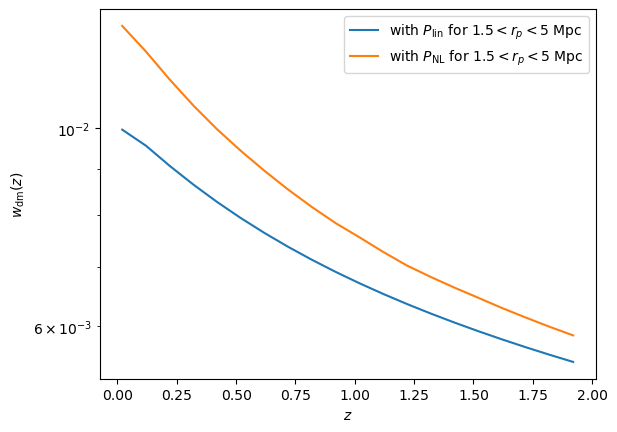

In [14]:
plt.figure(dpi=100)
plt.plot(Zlist,W_dm_lin,label=r'with $P_{\rm lin}$ for ' +str(rp_min)+'$<r_p<$'+str(rp_max)+' Mpc')
plt.plot(Zlist,W_dm_NL,label=r'with $P_{\rm NL}$ for ' +str(rp_min)+'$<r_p<$'+str(rp_max)+' Mpc')
plt.xlabel('$z$')
plt.ylabel(r'$w_{\rm dm}(z)$')
plt.yscale('log')
plt.legend()

### Now for the $\theta$ scale convention:

In [7]:
def xi_dm_theta(theta,z, typ):
    '''same as before for theta in deg instead of rp'''
    Hz=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+z))

    if typ=='linear':
        Plin_ell = [Plin(l,z) for l in Ell]
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,ell=Ell,C_ell=Plin_ell,theta=theta,type='NN',method='Legendre')
    
    if typ=='NL':
        PNL_ell = [PNL(l,z) for l in Ell]
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,ell=Ell,C_ell=PNL_ell,theta=theta,type='NN',method='Legendre')

def w_dm_theta(z,typ):
    '''same as before for theta  in deg instead of rp'''
    Hz=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+z))
    if typ=='linear':
        P_delta = [Plin(l,z) for l in Ell]
    if typ=='NL':
        P_delta = [PNL(l,z) for l in Ell]    
    
    #weight that should be normalised to unity
    def Wtheta(theta):
        return theta**alpha
    norm=quad(Wtheta,theta_min, theta_max,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]
        
    def xi_dm_int(theta):
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,ell=Ell,C_ell=P_delta,theta=theta,type='NN',method='Legendre')

    def Integ(theta):
        return Wtheta(theta)/norm*xi_dm_int(theta)
    
    return quad(Integ,theta_min, theta_max,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]


In [8]:
Ell=range(1,4000)
nlim=10000

theta_min=5/60 #deg
theta_max=30/60 #deg
alpha=0

zmin=0.02
Zlist=[zmin+i/10 for i in range(20)]
W_dm_lin_theta=[w_dm_theta(z,typ='linear') for z in Zlist]
W_dm_NL_theta=[w_dm_theta(z,typ='NL') for z in Zlist]


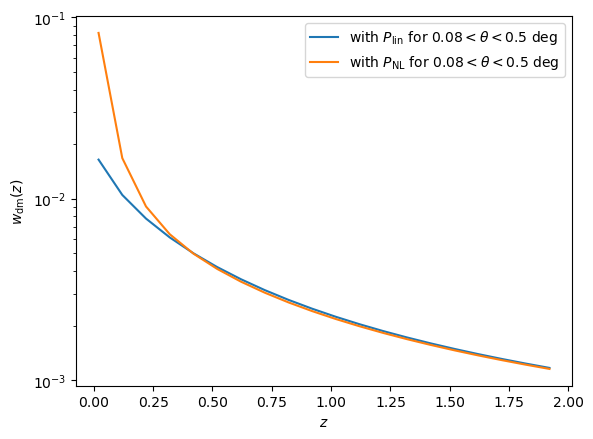

In [9]:
plt.figure(dpi=100)
plt.plot(Zlist,W_dm_lin_theta,label=r'with $P_{\rm lin}$ for ' +str(round(theta_min,2))+r'$<\theta<$'+str(round(theta_max,2))+' deg')
plt.plot(Zlist,W_dm_NL_theta,label=r'with $P_{\rm NL}$ for ' +str(round(theta_min,2))+r'$<\theta<$'+str(round(theta_max,2))+' deg')
plt.xlabel('$z$')
plt.ylabel(r'$w_{\rm dm}(z)$')
plt.legend()
plt.yscale('log')

For the  auto examples, we did wdm_NL for 1.5<rp<5 Mpc and 1< theta<10 deg, and 8 redshifts bins

In [72]:
z_examples=np.array([0.675+0.05*i for i in range(8)])
rp_min=1.5#Mpc! 
rp_max=5 #Mpc!
theta_min=1/60
theta_max=10/60
alpha=0

print('w for the Auto-corr example')
print([round(w_dm(z,typ='NL'),5) for z in z_examples])
print([round(w_dm_theta(z,typ='NL'),5)  for z in z_examples])

w for the Auto-corr example
[0.00871, 0.00852, 0.00833, 0.00814, 0.00797, 0.00781, 0.00767, 0.00753]
[0.00873, 0.00814, 0.00763, 0.00719, 0.00681, 0.00647, 0.00617, 0.0059]


# 2 - We compute the matrices for the  DESY6 article: 
We compute the clustering matrix A, and two magnification matrices D. 

# $A_{mr}$: clustering
Clustering matrix for cross-correlations between the elements the redshift basis {Km} and the reference samples {r}

$A_{mr}=b_r \int dz K_m(z)n_r(z)\omega_{dm}(z)$


In [11]:
#fiducial wdm:
Zlist=np.array([0.01+i*0.02 for i in range(60)])
rp_min=1.5#Mpc! 
rp_max=5 #Mpc!
alpha=-1
W_dm_NL=[w_dm(z,typ='NL') for z in Zlist]
w_dm_fid=interpolate.interp1d(Zlist,W_dm_NL)

In [15]:
def Amr(br,Km,nr,z_n):
    '''br is the galaxy bias for the reference sample r
       Km is the m element of the redshift basis {Km}
       nr is the redshift distribution of the ref sample r
       z_n is the redshift array for Km and nr
    '''
    zmin=z_n[0]
    zmax=z_n[-1]
    
    Km=interpolate.interp1d(z_n,Km)
    nr=interpolate.interp1d(z_n,nr)

    def Integ(z):
        return Km(z)*nr(z)*w_dm_fid(z)
        
    return br*quad(Integ,zmin, zmax,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]

# $D_{ab}$ magnification 
Magnification matrix between the samples a and b: a magnifies b

The two magnifications matrices can be generated from the same functions, switching a and b. 

$D_{ab}=\frac{3 \Omega_m H_0}{c} \int_{z_a}\,dz_a\,\frac{H_0}{H(z_a)}\,n_r(z_a)\omega_{dm}(z_a) \chi(z_a)(1+z_a)\,\int_{z_b>z_a}\,dz_b \, K_m(z_b)\frac{\chi(z_b)-\chi(z_a)}{\chi(z_b)}$

In [18]:
def Dab(Km,nr,z_n):
    '''we evaluate the magnification of nr with Km acting as a lens, i.e. Km magnifies nr
       Km is the redshift distribution of sample a
       nr is the redshift distribution of sample b
       z_n is the redshift array for Km and nr
    '''
    zmin=z_n[0]
    zmax=z_n[-1]
    
    Km=interpolate.interp1d(z_n,Km)
    nr=interpolate.interp1d(z_n,nr)
    
    def Integ_r(zr):
        #The integral over unknown u
        def Integ_u(zu):
            return Km(zu)*(chi(zu)-chi(zr))/chi(zu)
        # we integrate from zr to zmax
        Hzr=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+zr))
        return H0/Hzr*nr(zr)*w_dm_fid(zr)*(1+zr)*chi(zr)*quad(Integ_u,zr, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=nlim)[0]
    # cst times the integral over reference r
    return 3*Omega_m*H0/c_ls*quad(Integ_r,zmin, zmax,epsrel=10**(-3),epsabs=10**(-6),limit=nlim)[0]
        

Let's test these, for gaussians Km and nr functions, with different mu and sigma: 

In [42]:
# Evaluate the three matrices

Km=np.array([np.exp(-0.5*(Zlist-0.1*i)**2/0.1**2)/0.1/np.sqrt(2*math.pi) for i in range(1,12)])
Nr=np.array([np.exp(-0.5*(Zlist-0.15*i)**2/0.15**2)/0.15/np.sqrt(2*math.pi) for i in range(1,10)])


Clust=np.zeros((9,11))
Magn_mr=np.zeros((11,9))
Magn_rm=np.zeros((9,11))

for i in range(9):
    for j in range(11):
        n_i, n_j = Nr[i], Km[j]
        Clust[i, j] = Amr(1, n_i, n_j, Zlist)
        Magn_rm[i, j] = Dab(n_i, n_j, Zlist)
        Magn_mr[j, i] = Dab(n_j, n_i, Zlist)

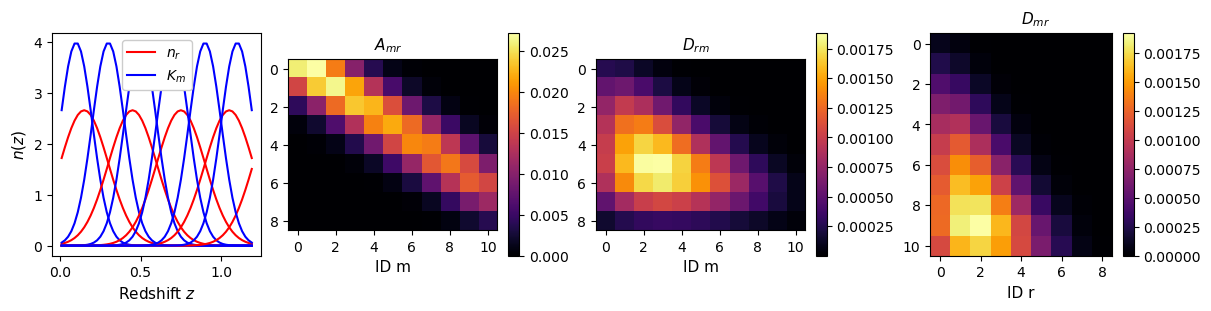

In [63]:
fig = plt.figure(constrained_layout=True, figsize=(12,3))
gs = fig.add_gridspec( 1,4)
ax = np.array([fig.add_subplot(gs[0]), fig.add_subplot(gs[1]),fig.add_subplot(gs[2]), fig.add_subplot(gs[3])])


for i in range(0,11,2):
    ax[0].plot(Zlist,Nr[i],color='red',label=r'$n_r$'if i==0 else '') if i<10 else next
    ax[0].plot(Zlist,Km[i],color='blue',label=r'$K_m$'if i==0 else '')

im1 = ax[1].imshow(Clust, cmap='inferno')
im2 = ax[2].imshow(Magn_rm, cmap='inferno')
im3 = ax[3].imshow(Magn_mr, cmap='inferno')


fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


ax[0].set_xlabel('Redshift $z$',fontsize=11)
ax[1].set_xlabel('ID m',fontsize=11)
ax[2].set_xlabel('ID m',fontsize=11)
ax[3].set_xlabel('ID r',fontsize=11)
ax[0].set_ylabel('$n(z)$',fontsize=11)

ax[1].set_xticks([0,2,4,6,8,10])
ax[2].set_xticks([0,2,4,6,8,10])
ax[3].set_xticks([0,2,4,6,8])

ax[3].set_yticks([0,2,4,6,8,10])
ax[2].set_yticks([0,2,4,6,8])
ax[1].set_yticks([0,2,4,6,8])

ax[1].text(4,-1,'$A_{mr}$',fontsize=11)
ax[2].text(4,-1,'$D_{rm}$',fontsize=11)
ax[3].text(4,-1,'$D_{mr}$',fontsize=11)
ax[0].legend(framealpha=1)